This notebook implements the ExpCGM framework to relate the atmosphere's radius and mean specific energy under various assumptions about the pressure profile and the gravitational potential.

In [65]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

## 1. Power‑Law Atmosphere in an NFW Potential
This first section assumes a constant pressure shape function $\alpha = 1.5$, where
$$
\alpha(r) = -\frac{d\ln P}{d\ln r}
$$
and an NFW gravitational potential with $A_{\rm NFW}=4.625$.

In [66]:
# Constants
A_NFW = 4.625

# Integration lower limit, since some functions starts become hard to integrate when very to close to 0
eps = 10**(-4)

# constant alpha of 1.5
alpha = 1.5

### Defining Pressure, Velocity Profiles and the Gravitational Potential

The normalized dimensionless pressure profile $f_P(x)$ is obtained by integrating the shape function. Here, $x = r/r_s$ for a scale radius $r_s$.
$$
f_P(r) = \exp \left[ -\int_1^{r/r_0} \frac{\alpha(x)}{x}dx \right]
$$
For a power-law atmosphere this becomes:
$$
f_P(r) = \left(\frac{r}{r_0}\right)^{-\alpha}
$$
The NFW potential with a zero point at $r=0$ is:
$$
\varphi(x) = A_{\rm NFW}\, v_\varphi^2\, \left[ 1 - \frac{\ln(1+x)}{x} \right]
$$
Where $v_\varphi$ is the maximum value of the velocity profile. With our choice of $A_{\rm NFW} = 4.625$, the circular velocity function becomes:
$$
v_c^2(x) = A_{\rm NFW}\, v_\varphi^2\, \left[ \frac{\ln(1+x)}{x} - \frac{1}{1+x} \right]
$$

In [67]:
# Defining the functions as described above for a constant alpha:

def f_P(x):        
    return x**(-alpha)

# The A_NFW * v_phi term simplifies later, so we can keep these dimensionless and only look at the shape of the function.

def phi(x):
    return 1 - np.log(1 + x) / x 

def vc2(x):
    return np.log(1 + x) / x - 1 / (1 + x)

### Defining the Integrals

We define the functions for each dimensionless integral along with their integrands.

Gas mass:
$$
I(x) = v_\varphi^2 \int_0^x \frac{\alpha(x)f_P(x)}{v_c^2(x)}x^2\,dx
$$
Gravitational energy:
$$
J_\varphi(x) = \int_0^x \frac{\alpha(x)f_P(x)\varphi(x)}{v_c^2(x)}x^2\,dx
$$
Thermal energy:
$$
J_{\rm th}(x) = \frac{3}{2} \int_0^x f_P(x)\,x^2\,dx
$$
And the total specific energy
$$
F(x) = \frac{J_\varphi(x) + J_{\rm th}(x)}{I(x)}
$$
is defined such that:
$$
\varepsilon_{\rm CGM} = \frac{E_{\rm CGM}}{M_{\rm CGM}} = v_\varphi^2\, F\left(\frac{r_{\rm CGM}}{r_0}\right)
$$

In [68]:
def integrandI(t): # We define the integrands as seperate functions before integrating them
    return f_P(t) * t**2 / vc2(t)

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return alpha / A_NFW * resultI

def integrandJphi(t):
    return f_P(t) * phi(t) / vc2(t) * t**2

def Jphi(x):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, limit=50)
    return alpha * resultJphi

def integrandJth(t):
    return f_P(t) * t**2

def Jth(x):
    resultJth, _ = integrate.quad(integrandJth, eps, x, limit=50)
    return 3 / 2 * resultJth

def F(x):
    return (Jphi(x) + Jth(x)) / I(x)


### Plotting

We compute $F(x_{\rm CGM})$ as a function of $x_{\rm CGM}$, then invert the axes to obtain a plot of atmospheric radius vs. mean specific energy. 

The dashed line shows how the normalization $P_0 \propto 1/I(x_{\rm CGM})$ of the atmosphere’s pressure profile declines as $\varepsilon_{\rm CGM}$ rises and the atmosphere expands.

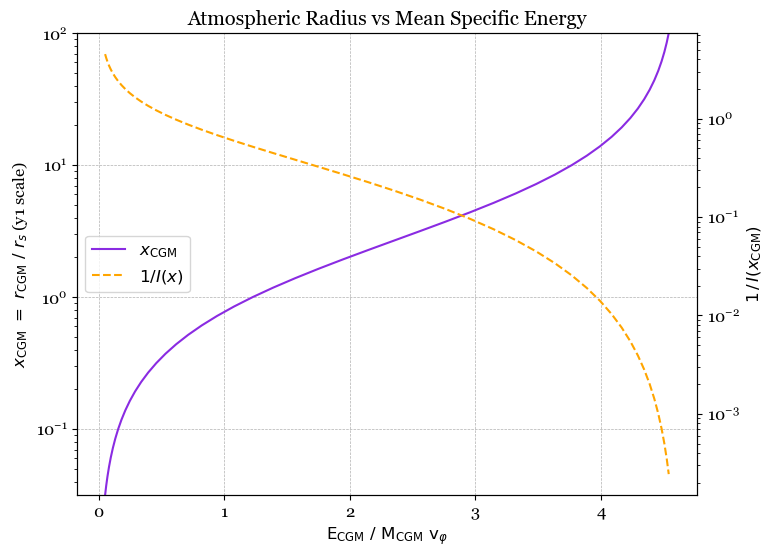

In [69]:
# Plotting the results
x_values = np.logspace(-1.5, 2, 50)
y1_values = [F(x) for x in x_values]
y2_values = [1/I(x) for x in x_values]

gfont = {'fontname':'georgia'}
plt.rcParams['font.family'] = 'georgia' 
plt.rcParams['font.size'] = 12 

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(y1_values, x_values, color='blueviolet', label='$x_{\\text{CGM}}$')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12, **gfont)
ax1.set_ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$ (y1 scale)', fontsize=12, **gfont)
ax1.set_ylim(10**-1.5, 10**2)
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(y1_values, y2_values, color='orange', linestyle='--', label='$1/I(x)$')
ax2.set_ylabel('$1\\,/\\,I(x_{\\text{CGM}})$', fontsize=12, **gfont)
ax2.set_yscale('log')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left')

plt.title('Atmospheric Radius vs Mean Specific Energy', **gfont)
plt.show()


## 2. Variable Shape Function

In this section we use a shape function $\alpha(x)$ that varies with radius. The simplified cosmological profile 
$$
\alpha(r) = 1.7 \left( \frac{2r/r_{\rm max}}{1+r/r_{\rm max}} \right)
$$
represents a cosmological atmosphere. It is designed to have $\alpha \approx 1.7$ near the radius $r_{\rm max} = 2.16\, r_s$, where $v_c^2(r)$ peaks in an NFW gravitational potential.


In [ ]:
rmax = 2.16

A_NFW = 4.625
eps = 10**(-4)

def alpha(x):
    return (3.4*x)/(rmax + x)

We now have to use the integral form of $f_P(x)$ since alpha is not constant. 
$$
f_P(r) = \exp \left[ -\int_1^{r/r_0} \frac{\alpha(x)}{x}dx \right]
$$

In [71]:
def integrandf_P(t):
    return alpha(t) / t

def f_P(x):        
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, limit=50)
    return np.exp(-resultf_P)


We also redefine the energy integrals so they have $\alpha(x)$ inside them. We can also define the $v_c^2(x)$ and $\varphi(x)$ functions the same way again so each section of the notebook is self-contained.

In [72]:
def vc2(x):
    return np.log(1+x) / x - 1 / (1+x)

def phi(x):
    return 1- np.log(1+x)/x

def integrandI(t):
    return alpha(t) * f_P(t) * t**2 / vc2(t)

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return 1 / A_NFW * resultI

def integrandJphi(t):
    return alpha(t) * f_P(t) * phi(t) / vc2(t) * t**2

def Jphi(x):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, limit=50)
    return resultJphi

def integrandJth(t):
    return f_P(t) * t**2

def Jth(x):
    resultJth, _ = integrate.quad(integrandJth, eps, x, limit=50)
    return 3 / 2 * resultJth

def F(x):
    return (Jphi(x) + Jth(x)) / I(x)

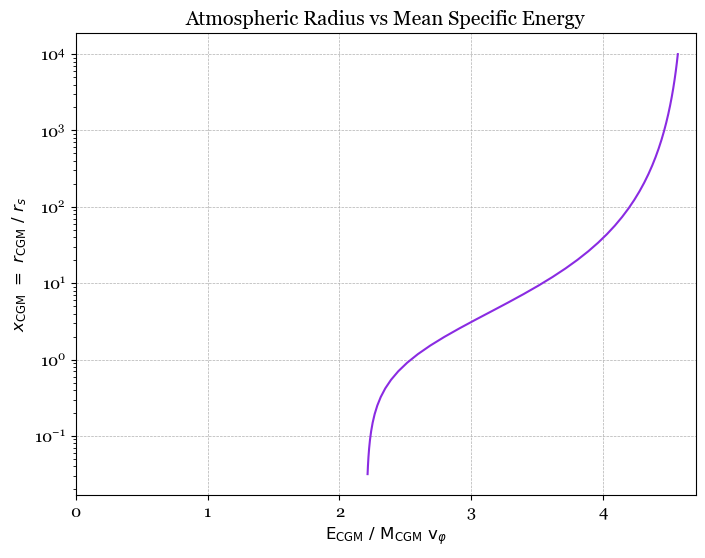

In [73]:
# Plotting the results

x_values = np.logspace(-1.5, 4, 50)
y_values = [F(x) for x in x_values]

gfont = {'fontname':'georgia'}
plt.rcParams['font.family'] = 'georgia' 
plt.rcParams['font.size'] = 12 
plt.figure(figsize=(8, 6))
plt.plot(y_values, x_values, color='blueviolet')
plt.xlim(0, 4.7)
plt.xscale('linear')
plt.yscale('log')
plt.title('Atmospheric Radius vs Mean Specific Energy', **gfont)
plt.xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12)
plt.ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## 3. Including a Central Galaxy

In addition to the NFW profile, we can add a central galaxy to the potential using the Hernquist model:
$$
v_{\rm H}^2(r) = \frac{GM_*r}{(r+r_{\rm H})^2}
$$
Most central galaxies have a maximum circular velocity similar to the maximum circular velocity $v_\varphi$ of the surrounding halo. 

Therefore we assume that $\max(v_{\rm H}) = v_\varphi$, so $r_{\rm H} = GM_*/4v_\varphi^2$.

Using this, and dividing by the scale radius, we get the circular velocity profile
$$
v_{\rm H}^2(x) =  \frac{4 v_\varphi^2 (r_{\rm H}/r_0)x}{(x + r_{\rm H}/r_0)^2}
$$
We use the scale radius $r_H=0.2 r_0$, and combine this with the NFW profile.
$$
v_c^2(x) = v_{\rm NFW}^2(x) + v_{\rm H}^2(x)
$$

In [ ]:
A_NFW = 4.625
eps = 10**(-4)
rmax = 2.163

r_H = 0.2 # The Hernquist radius where v_c is maximized in the Hernquist model, as a fraction of r_0


# Defining the NFW and Hernquist models seperately, then adding them together
# Once again we can ignore the v_phi term as it cancels out, and keep the quantities dimensionless.

def v2_NFW(x):
    return A_NFW * (np.log(1+x) / x - 1 / (1+x))

def v2_H(x):
    return 4 * r_H * x / (x + r_H)**2

def vc2(x):
    return v2_NFW(x) + v2_H(x)

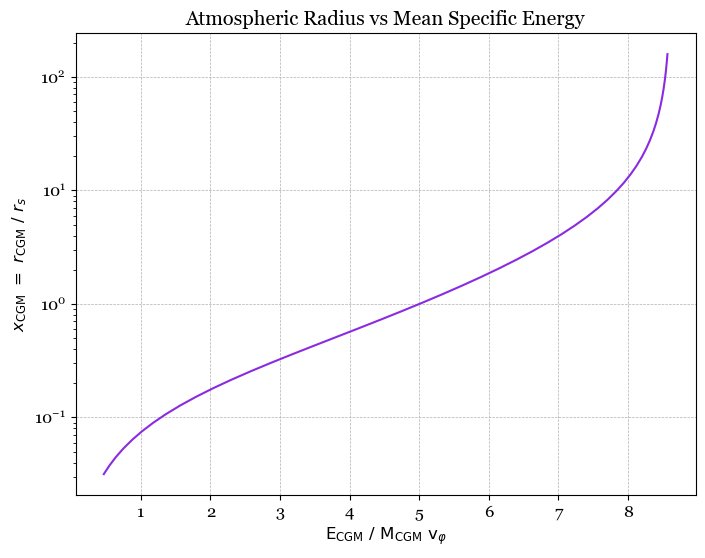

In [ ]:
# In this version, if we let both v_c^2 and alpha go to 0, the J_phi integral misbehaves causing double values
# One solution to this is to go back to a model with constant alpha.
# Another is to give a lower bound to alpha, taking the maximum of the two functions
# This approach works for down to alpha = ~0.7, though it gives an increasingly jagged graph

def alpha(x):
    # return 3.4 * ( x/rmax /(1+x/rmax) )   # option 1
    
    return 1.5   # option 2
    
    # alpha1 = 3.4 * ( x/rmax /(1+x/rmax) )
    # alpha2 = 0.7
    # return max(alpha1,alpha2)   # option 3

def integrandf_P(t):
    return alpha(t) / t

def f_P(x):
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, limit=50)
    return np.exp(-resultf_P)

def integrandphi(t):
    return vc2(t) / t

def phi(x):
    resultphi, _ = integrate.quad(integrandphi, eps, x, limit=50)
    return resultphi

def integrandI(t):
    return alpha(t) * f_P(t) * t**2 / (vc2(t))

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return resultI

def integrandJphi(t):
    return alpha(t) * f_P(t) * phi(t) / vc2(t) * t**2

def Jphi(x):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, limit=50)
    return resultJphi

def integrandJth(t):
    return f_P(t) * t**2

def Jth(x):
    resultJth, _ = integrate.quad(integrandJth, eps, x, limit=50)
    return 3 / 2 * resultJth

def F(x):
    return (Jth(x)+Jphi(x)) / I(x)

In [ ]:
# Plotting the results

x_values = np.logspace(-1.5, 2.2, 50)
y_values = [F(x) for x in x_values]

gfont = {'fontname':'georgia'}
plt.rcParams['font.family'] = 'georgia' 
plt.rcParams['font.size'] = 12 
plt.figure(figsize=(8, 6))
plt.plot(y_values, x_values, color='blueviolet')
plt.title('Atmospheric Radius vs Mean Specific Energy', **gfont)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12)
plt.ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Now that we have the central galaxy as well, we can plot the rotation curve being used as a reference.

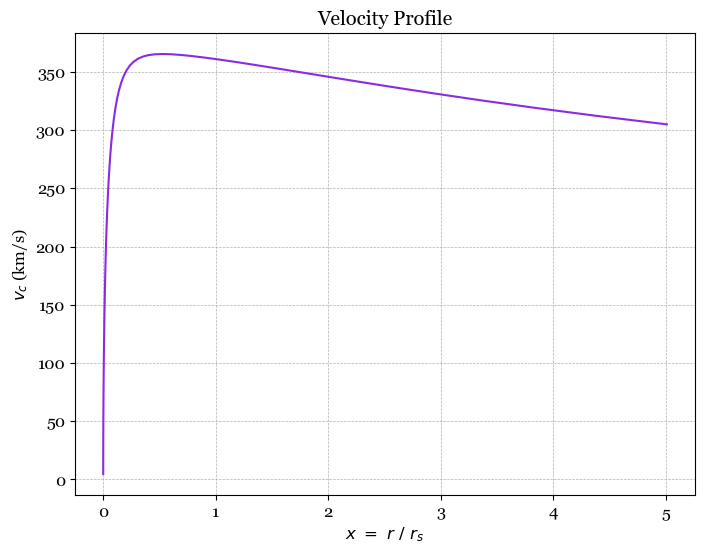

In [ ]:
x_values_2 = np.logspace(-5, 0.7, 100)
v_c_values = [np.sqrt(vc2(x))/1e3 for x in x_values_2]

gfont = {'fontname':'georgia'}
plt.rcParams['font.family'] = 'georgia' 
plt.rcParams['font.size'] = 12 
plt.figure(figsize=(8, 6))
plt.plot(x_values_2, v_c_values, color='blueviolet')
plt.xscale('linear')
plt.yscale('linear')
plt.title('Velocity Profile', **gfont)
plt.xlabel(r'$x \ = \ r \ / \ r_s$', fontsize=12)
plt.ylabel(r'$v_c$ (km/s)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()